In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")    # because pcolormesh doesn't like being given cell centres instead of vertices

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define projection to be used for all maps
cproj = cartopy.crs.epsg(3347)  # native EPSG of homogenous fire regions
cproj.bounds = (3393069.0021458385, 9436930.849558635, 750000, 4340847.387925235)      # modify bounds to focus on region of interest

hfrz = gpd.read_file("sf_hfrz")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Method to reproject lat/lon onto Lambert coordinates
def latlon_to_lambert(da):
    
    # convert dataArray to dataframe
    df = da.to_dataframe().reset_index()
    
    # convert to geoDataFrame, reproject points to Statistics Canada Lambert 
    gdf = gpd.GeoDataFrame(df[df.columns[-1]], geometry = gpd.points_from_xy(df.longitude, df.latitude))
    gdf = gdf.set_crs(epsg = 4326).to_crs(epsg = 3347)
    
    x = np.reshape(np.array(gdf.geometry.x), da.shape)
    y = np.reshape(np.array(gdf.geometry.y), da.shape)
    
    return x,y

---
# **Exploratory**

- make a map of danger thresholds per province & look at ndays exceeding each level
- MODIS/VIIRS active fires

## **Elevation**

In [54]:
elev = wrap_lon(xr.open_dataset("~/Data/elev.0.25-deg.nc").squeeze(drop = True).data).sel(lon = slice(-140.75, -52.75), lat = slice(43.5, 69.5))
elev = elev.assign_coords({k : (["lat", "lon"], v) for k,v in zip(["x","y"], latlon_to_lambert(elev.rename(lon = "longitude", lat = "latitude")))})

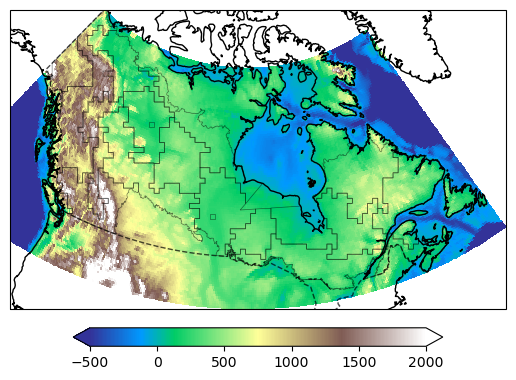

In [68]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})
cbar = ax.pcolormesh(elev.x, elev.y, elev, cmap = "terrain", vmin = -500, vmax = 2000)

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.05, extend = "both")

## **HFRZs & provinces**

In [87]:
provinces = gpd.read_file("sf_provinces").to_crs(cproj).set_index("PRENAME")
fwi_extreme = {"fwi_extreme" : {'Newfoundland and Labrador' : 20,
               'Prince Edward Island' : 21,
               'Nova Scotia' : 23,
               'New Brunswick' : 23, 
               'Quebec' : 20,
               'Ontario' : 22,
               'Manitoba' : 33, 
               'Saskatchewan' : 30,
               'Alberta' : 29, 
               'British Columbia' : 35, # temporary value until I can get a shapefile for the smaller regions
               'Yukon' : 28, 
               'Northwest Territories' : 23,
               'Nunavut' : 23}}
provinces = pd.merge(provinces, pd.DataFrame.from_dict(fwi_extreme), left_index = True, right_index = True)

provinces[["geometry", "fwi_extreme"]].to_file("sf_firerisk")

NameError: name 'provinces' is not defined

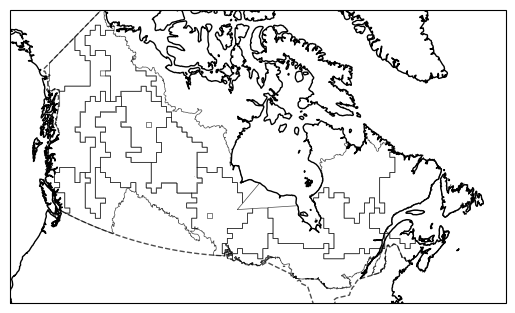

In [139]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

provinces.plot(ax = ax, column = "fwi_extreme", cmap = "YlOrRd")
# plt.colorbar(cbar, ax = ax)

In [130]:
hfrz_px = {r[1].NAMES_SHOR : r[1].geometry.representative_point() for r in hfrz.iterrows()}

In [135]:
plot([(x,y) for x,y in zip(hfrz.geometry.representative_point().x , hfrz.geometry.representative_point().y)])

TypeError: scatter() takes from 2 to 11 positional arguments but 16 were given

In [ ]:
[ax.annotate(k, xy = v for k,v in hfrz_px.items()]

TypeError: cannot unpack non-iterable Point object

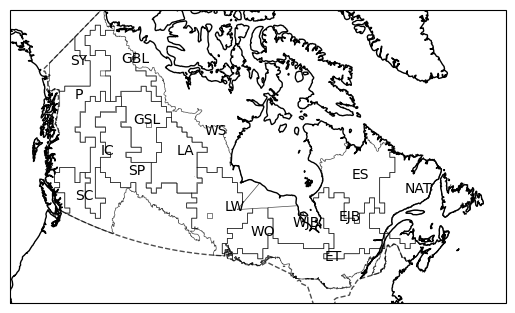

In [112]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

for i in range(16):
    r = hfrz.loc[[i]]
    ax.annotate(hfrz.loc[i].NAMES_SHOR, xy = [r.geometry.representative_point().x, r.geometry.representative_point().y], color = "k")

Text(0    7.453864e+06
dtype: float64, 0    2.349349e+06
dtype: float64, 'x')

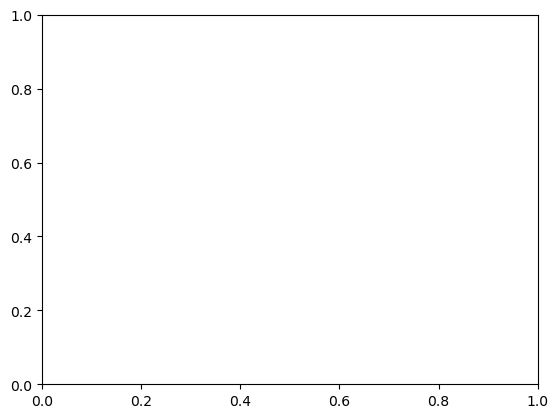

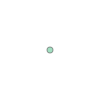

In [66]:
[ax.annotate(k, xy = v.values(), fontweight = "bold", textcoords="offset points", xytext=(0,-12), ha='center') for k, v in px.items()]

,grid60km_n,NAMES,NAMES_SHOR,geometry
15,16.0,Pacific zone,P,"MULTIPOLYGON (((3971266.688 1942199.532, 39709..."


TypeError: cannot unpack non-iterable Point object

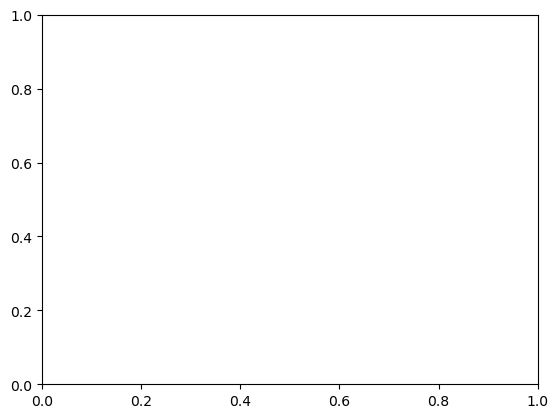

In [87]:
plt.annotate(i, hfrz.iloc[i].geometry.representative_point())

In [77]:
[px(r) for r in hfrz.iloc[[i]]]

AttributeError: 'str' object has no attribute 'geometry'

---
---
# **FWI exploratory (ERA5)**

## **Map of cumulative DSR**

In [34]:
fwi = xr.concat([xr.open_dataset(fnm).sel(time = "2023") for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx
fwi = fwi.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(fwi.isel(time = 0, region = 0)))})

dsr = (fwi ** 1.77) * 0.0272
cumdsr = dsr.sum(["region", "time"]).where(dsr.sum(["region", "time"]) > 0)

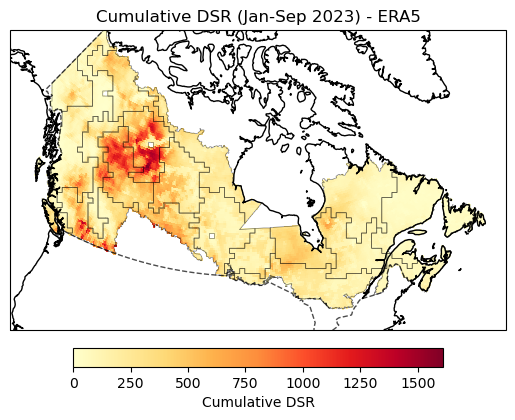

In [35]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})
cbar = ax.pcolormesh(cumdsr.x, cumdsr.y, cumdsr, cmap = "YlOrRd", vmin = 0)
ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.05, label = "Cumulative DSR")
plt.title("Cumulative DSR (Jan-Sep 2023) - ERA5")

plt.savefig("fig/expl_era5_cumDSR-2023.png")

### **Number of fire danger days**

In [17]:
sf_fr = gpd.read_file("sf_firerisk").dissolve(by = "fwi_extrem").to_crs("epsg:4326")
fwi = xr.concat([xr.open_dataset(fnm).sel(time = "2023") for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx

# create a regionmask of the FWI threshold for extreme fire risk
rm_fr = regionmask.mask_geopandas(sf_fr, fwi.longitude, fwi.latitude)
rm_fr = rm_fr.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(rm_fr))})

# identify days of extreme fire risk (& mask out regions without fwi data)
fr = xr.ones_like(fwi).where(fwi >= rm_fr, 0).sum(["time", "region"])
fr = fr.where(fwi.sum(["time", "region"]) > 0)

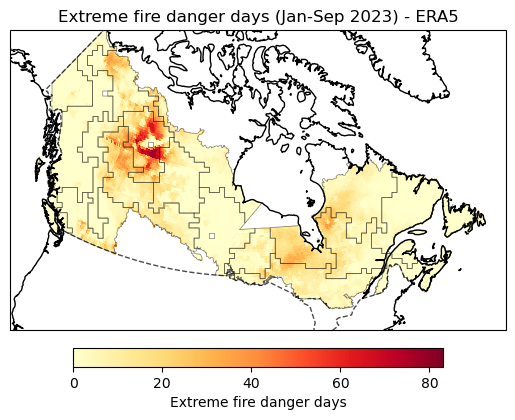

In [36]:
# number of days of extreme fire risk
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

cbar = ax.pcolormesh(fr.x, fr.y, fr, cmap = "YlOrRd", vmin = 0)
ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.05, label = "Extreme fire danger days")

plt.title("Extreme fire danger days (Jan-Sep 2023) - ERA5")

plt.savefig("fig/expl_era5_fire-danger-days-2023.png")

## **cumDSR per HFRZ**

In [2]:
hfrz_dsr = [((xr.open_dataset(fnm).fwinx ** 1.77) * 0.0272).mean(["latitude", "longitude"]) for fnm in sorted(glob.glob("data/era5_fwi_hfrz-*.nc"))]
hfrz_dsr = xr.concat(hfrz_dsr, "region").rename("dsr")
hfrz_dsr.to_netcdf("data/era5_dsr_hfrz-ts.nc")

### **cumDSR relative to previous years**

In [37]:
hfrz_dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

In [165]:
hfrz_cdsr = xr.concat([hfrz_dsr.sel(time = str(y)).cumsum("time") for y in range(1950,2023)], "time")

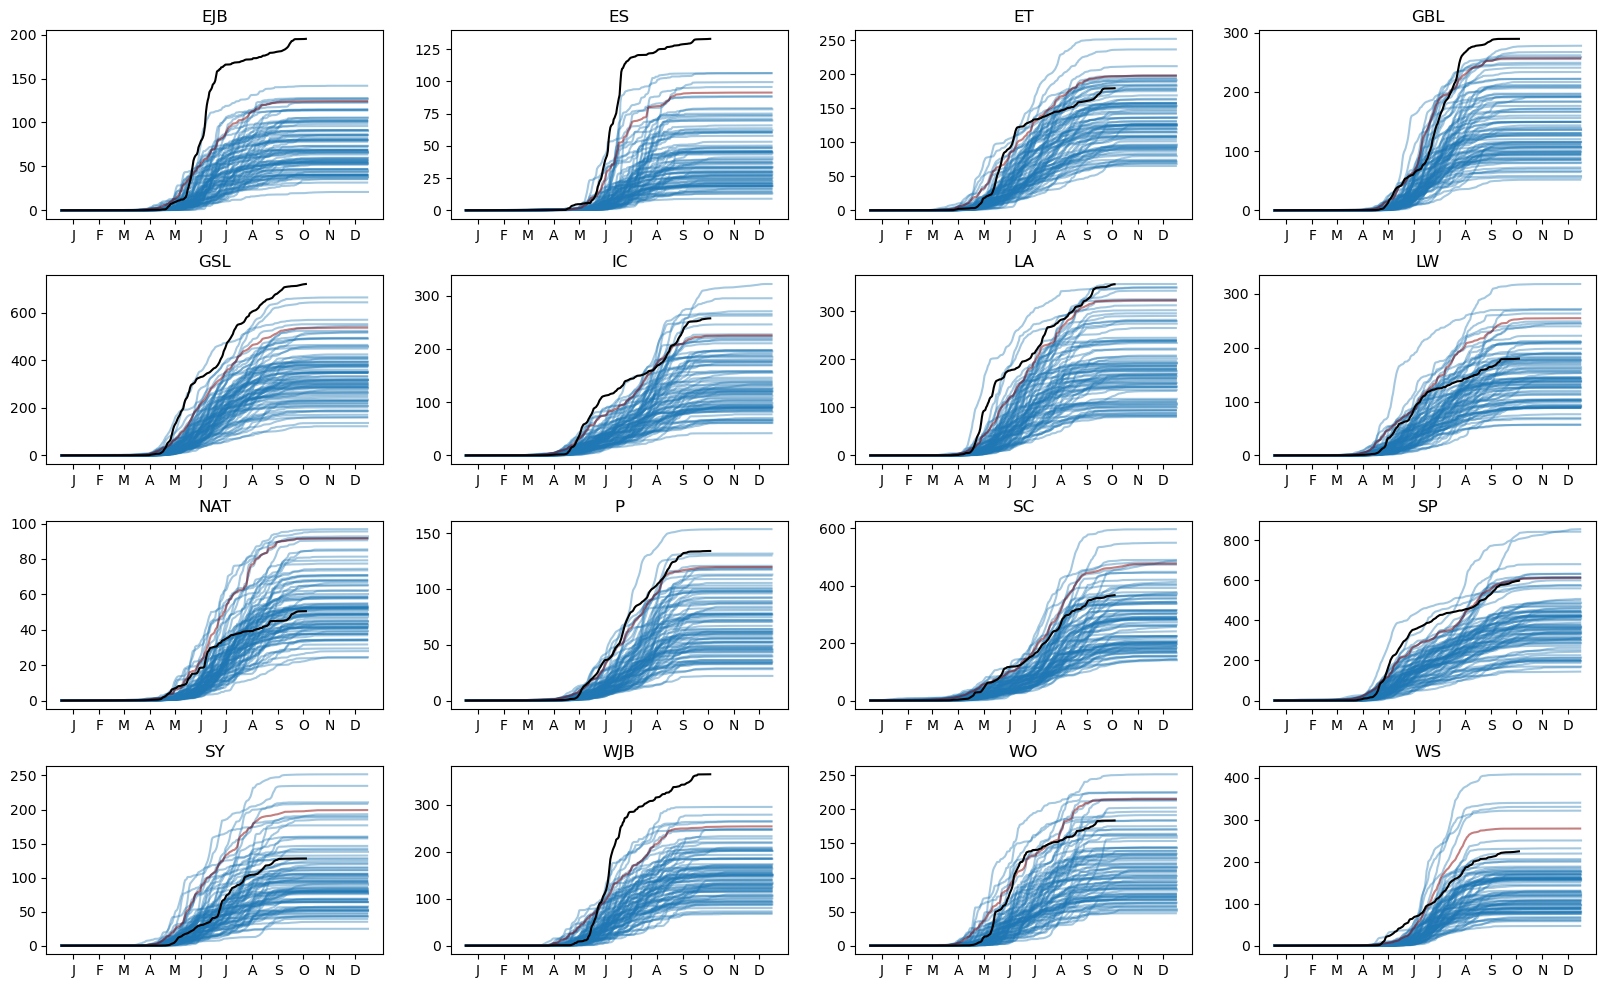

In [175]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    dsr_ts = hfrz_dsr.isel(region = i)
    
    for y in range(1941,2022):
        dsr_y = dsr_ts.sel(time = str(y))
        ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.4)
    
    # 95th percentile of cumsum
    ax.plot(dsr_ts.sel(time = "2022").time.dt.dayofyear, hfrz_cdsr.isel(region = i).groupby("time.dayofyear").quantile(0.95)[:-1], color = "darkred", alpha = 0.5, label = "95th percentile")
    
    y = 2023
    dsr_y = dsr_ts.sel(time = str(y))
    ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "k", alpha = 1, label = "2023")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)

    ax.set_title(dsr_ts.region_name.values)
    
plt.savefig("fig/expl_era5_cumDSR-per-hfrz.png")

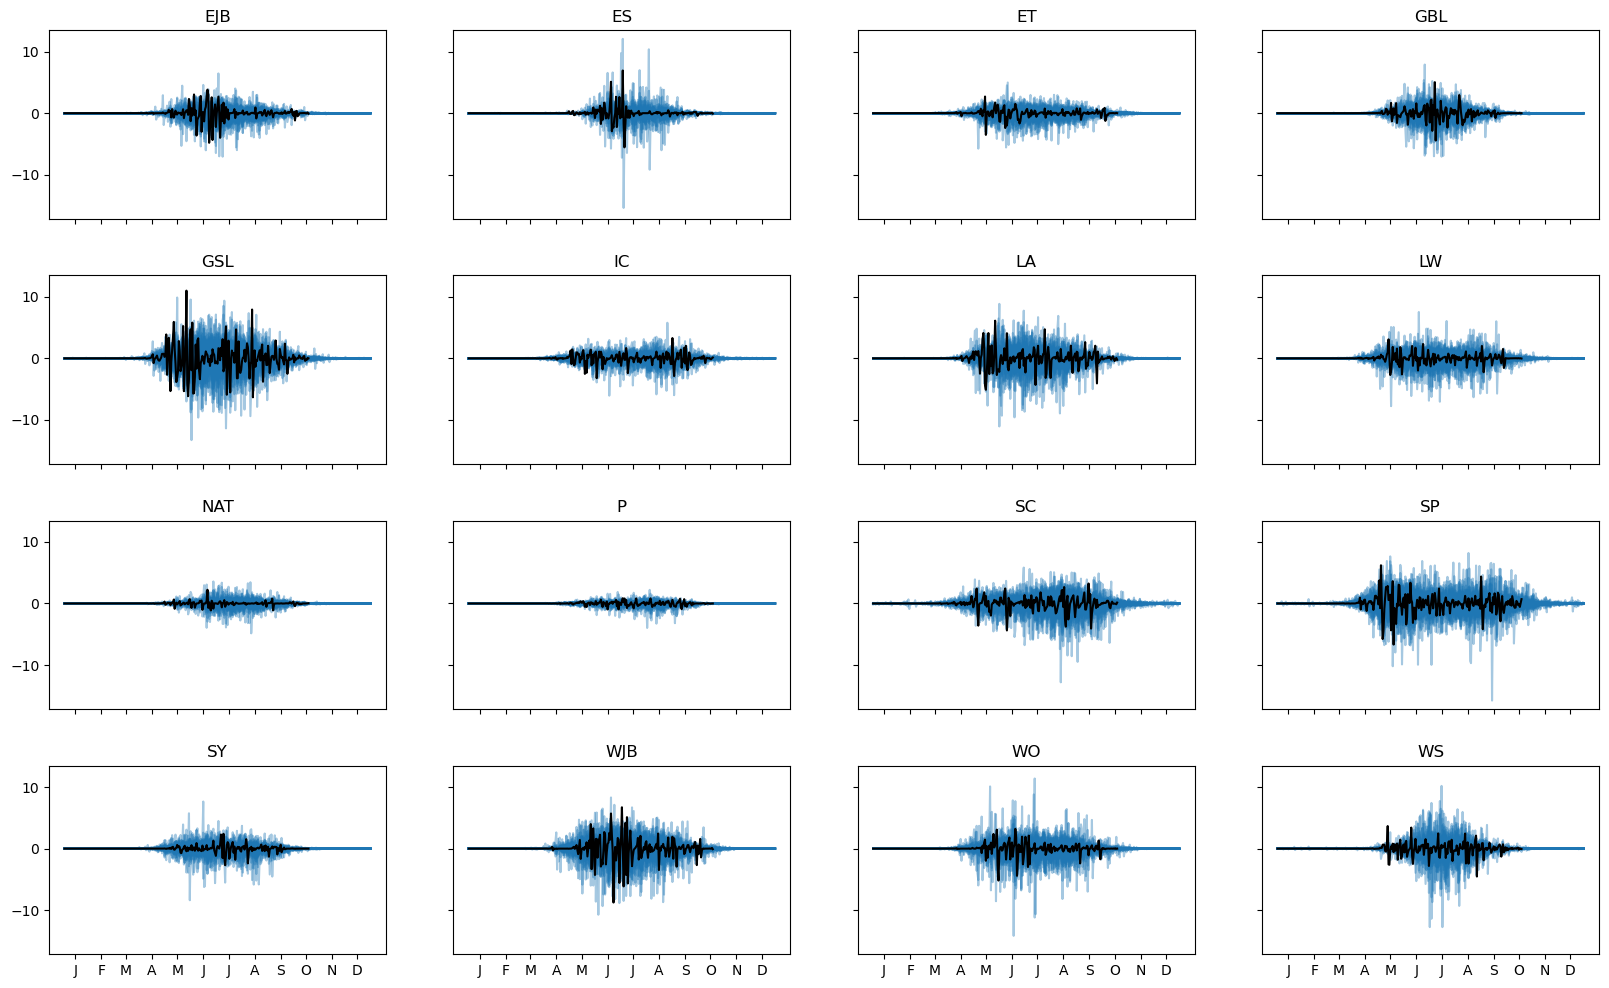

In [176]:
# when did the greatest increases occur?
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    dsr_ts = hfrz_dsr.isel(region = i)
    
    for y in range(1941,2022):
        dsr_y = dsr_ts.sel(time = str(y))
        ax.plot(dsr_y.time.dt.dayofyear[1:], dsr_y.diff("time"), color = "tab:blue", alpha = 0.4)
        
    y = 2023
    dsr_y = dsr_ts.sel(time = str(y))
    ax.plot(dsr_y.time.dt.dayofyear[1:], dsr_y.diff("time"), color = "k", alpha = 1, label = "2023")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)

    ax.set_title(dsr_ts.region_name.values)
    
plt.savefig("fig/expl_era5_cumDSR-diff-per-hfrz.png")

### **time series of annual cumDSR (to end of September)**

In [30]:
hfrz_dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr

# total DSR over each year (currently only up to end of September due to partial 2023 data)
cdsr = hfrz_dsr.sel(time = [m <= 9 for m in hfrz_dsr.time.dt.month]).resample(time = "AS-JAN").sum()

cdsr.assign_coords(region = cdsr.region_name, time = cdsr.time.dt.year).rename(time = "year").reset_coords(drop = True).to_pandas().transpose().to_csv("data/era5_cdsr.csv")

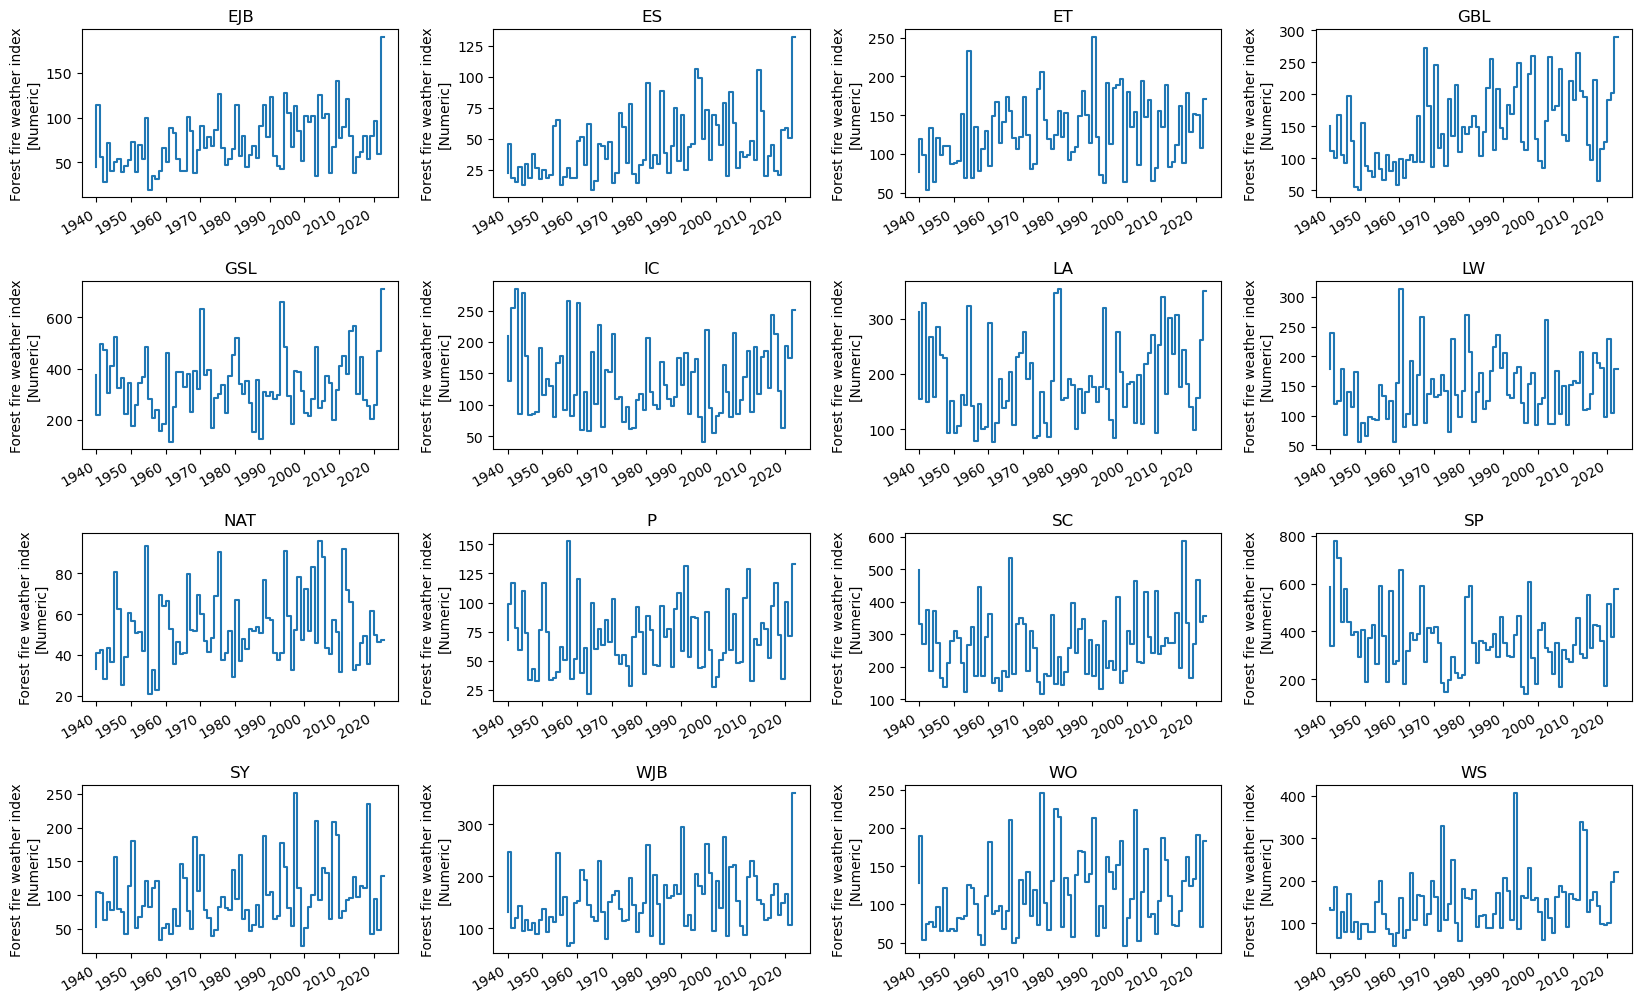

In [36]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100)
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    cdsr_ts = cdsr.isel(region = i)
    cdsr_ts.plot(ax = ax, drawstyle = "steps")

    ax.set_title(cdsr_ts.region_name.values)
    ax.set_xlabel("")